In [31]:
pip install pandas numpy matplotlib

In [32]:
import pandas as pd

df = pd.read_csv("dgrav.xyz", sep=r"\s+", header=None)

print(df.head())
print(df.columns)

                              0
0  latitude,longitude,grav_anom
1          81.16667,170.0,-9999
2      81.16667,170.04167,-9999
3      81.16667,170.08333,-9999
4        81.16667,170.125,-9999
Index([0], dtype='int64')


In [33]:
import numpy as np
import pandas as pd

# The original df has all data in a single column '0'
# Split the single column into multiple columns using ',' as a delimiter
new_df = df[0].str.split(',', expand=True)

# Set the first row as the header for the new DataFrame
new_df.columns = new_df.iloc[0]

# Drop the first row which is now the header
new_df = new_df[1:]

# Convert relevant columns to numeric types
new_df['latitude'] = pd.to_numeric(new_df['latitude'])
new_df['longitude'] = pd.to_numeric(new_df['longitude'])
new_df['grav_anom'] = pd.to_numeric(new_df['grav_anom'])

# Rename columns to match the arguments expected by the pivot function
new_df = new_df.rename(columns={'latitude': 'lat', 'longitude': 'lon', 'grav_anom': 'gravity'})

# Now pivot the corrected DataFrame
grid = new_df.pivot(index="lat", columns="lon", values="gravity")

gravity_map = grid.values

In [34]:
# remove invalid gravity values
new_df = new_df[new_df["gravity"] != -9999]
new_df = new_df.dropna()
new_df = new_df.sort_values(["lat","lon"])

In [35]:
grid = new_df.pivot(index="lat", columns="lon", values="gravity")
gravity_map = grid.values
print(gravity_map.shape)

(1824, 4302)


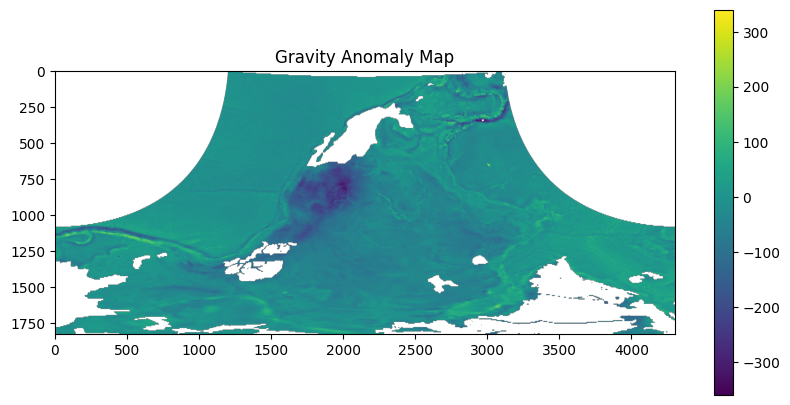

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.imshow(gravity_map)
plt.title("Gravity Anomaly Map")
plt.colorbar()
plt.show()

In [37]:
import numpy as np

gravity_map = np.nan_to_num(gravity_map)

gravity_map = (gravity_map - np.mean(gravity_map)) / np.std(gravity_map)

In [38]:
basement_depth = -gravity_map * 10

In [39]:
X = gravity_map[np.newaxis, np.newaxis, :, :]
y = basement_depth[np.newaxis, np.newaxis, :, :]

In [40]:
!pip install torch

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim

In [42]:
input_tensor = torch.tensor(X, dtype=torch.float32)
target_tensor = torch.tensor(y, dtype=torch.float32)

print(input_tensor.shape)

torch.Size([1, 1, 1824, 4302])


In [43]:
class GravityCNN(nn.Module):
    def __init__(self):
        super(GravityCNN, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.model(x)

model = GravityCNN()
print(model)

GravityCNN(
  (model): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


In [44]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [45]:
epochs = 100

for epoch in range(epochs):
    prediction = model(input_tensor)

    loss = loss_fn(prediction, target_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 98.9306
Epoch 2, Loss: 98.2427
Epoch 3, Loss: 97.4957
Epoch 4, Loss: 96.6903
Epoch 5, Loss: 95.8196
Epoch 6, Loss: 94.8673
Epoch 7, Loss: 93.8348
Epoch 8, Loss: 92.7227
Epoch 9, Loss: 91.5211
Epoch 10, Loss: 90.2269
Epoch 11, Loss: 88.8606
Epoch 12, Loss: 87.3925
Epoch 13, Loss: 85.8171
Epoch 14, Loss: 84.1310
Epoch 15, Loss: 82.3315
Epoch 16, Loss: 80.4167
Epoch 17, Loss: 78.3855
Epoch 18, Loss: 76.2385
Epoch 19, Loss: 73.9769
Epoch 20, Loss: 71.6004
Epoch 21, Loss: 69.1082
Epoch 22, Loss: 66.5021
Epoch 23, Loss: 63.7852
Epoch 24, Loss: 60.9622
Epoch 25, Loss: 58.0391
Epoch 26, Loss: 55.0236
Epoch 27, Loss: 51.9250
Epoch 28, Loss: 48.7545
Epoch 29, Loss: 45.5251
Epoch 30, Loss: 42.2520
Epoch 31, Loss: 38.9523
Epoch 32, Loss: 35.6454
Epoch 33, Loss: 32.3525
Epoch 34, Loss: 29.0971
Epoch 35, Loss: 25.9046
Epoch 36, Loss: 22.8025
Epoch 37, Loss: 19.8197
Epoch 38, Loss: 16.9861
Epoch 39, Loss: 14.3314
Epoch 40, Loss: 11.8846
Epoch 41, Loss: 9.6728
Epoch 42, Loss: 7.7196
Epo

In [46]:
predicted = model(input_tensor).detach().numpy()[0,0]

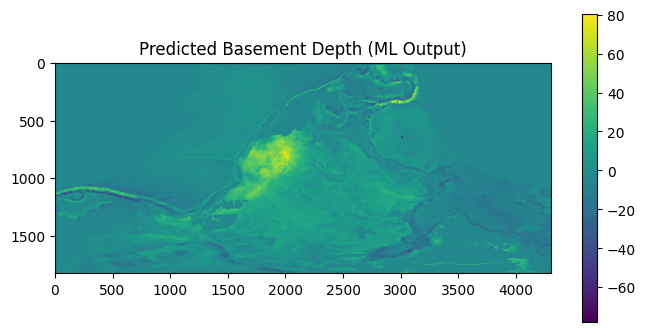

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.imshow(predicted)
plt.title("Predicted Basement Depth (ML Output)")
plt.colorbar()
plt.show()